# HOMEWORK #1: kNN&SVM
#### Luigi Ferrettino, S254300

We would like to train, validate and test some models by doing parameters tuning. In order to archieve it, the dataset will be splitted in a train set, a validation set and a test set. The second one will be used to evaluate the model with a different set of k/hyperparameters in order to choose the set of parameters that gives the highest accuracy on the validation set. After the tuning on the validation set has been done, we will check the performance of our model on the test set.


In [1]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from lib import *

## Dataset and preprocessing

Once we have loaded the Wine dataset, we could use some dimensionality reduction technique, but we just take the first two features of the dataset and discard the other ones (applying a PCA reduction at 2 dimensions using all the features available could gain a lot the prediction result, because instead of losing a lot of information by discarding the other features we could limit the loss by projecting all the features in a max-variance plane).

Then the dataset will be shuffled and splitted into train (50%), validation (20%) and test (30%) sets.

In [2]:
X, y = datasets.load_wine(return_X_y=True)
X = X[:, 0:2]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2857, random_state=0)

Preprocessing is the foundamental task, so once we have splitted the three sets, it is time to normalize. 
If we normalize every set, we leak information about either the response (from the future, from our hold out data set into the training) or the evaluation of our model. This can cause considerable optimism bias in our model evaluation.
The idea in model validation is to mimic the situation we would be in when our model is making production decisions, when we do not have access to the true response. The consequence is that we cannot use the response in the test set for anything except comparing to our predicted values.

Another way to approach it is to imagine that we only have access to one data point from our hold out at a time (a common situation for production models). Anything we cannot do under this assumption we should hold in great suspicion. Clearly, one thing we cannot do is aggregate over all new data-points past and future to normalize our production stream of data, so doing the same for model validation is invalid.
We don't have to worry about the mean of our test set being non-zero, that's a better situation to be in than biasing our hold out performance estimates. Though, of course, if the test is truly drawn from the same underlying distribution as our train (an essential assumption in statistical learning), said mean should come out as approximately zero.

But in this case we will not normaliza, as we are analyzing a really reduced and not-so-dispersed dataset. 

## K-nearest neighbor
k-NN is one of the most easy algorithms for ML classification/regression. An new object is classified on the majority vote from the k nearest neighbors. The parameter k is odd (in binary classifications it could happen some parity situation), it must be tuned and it depends on the dataset. Generally, for an increasing k the noise which compromises the classification decreases, but the criterion of choice for the class becomes more blurred. The choice can be made through heuristic techniques such as cross-validation. 

For what concerns our case, we will:
1. Train on the train set
2. Evaluate for k=1, k=3, k=5 and k=7
3. Choose the best model
4. Apply it on the test set


### Model training and evaluation
In order to train the models we instantiate a **KNeighborsClassifierfor** for each k (*n_jobs* set to -1 forces the program to use the maximum cores available on the running machine, since this classifier is as simple as computational intensive) and we fit on the train set. At the same time we use the model to predict on the validation set and we save everything in a data structure and, using a personal library, we plot the four models with the decision boundaries.


********************************
TASK: kNN classification
********************************

Best prediction accuracy on validation set found with k = 7
80.56%



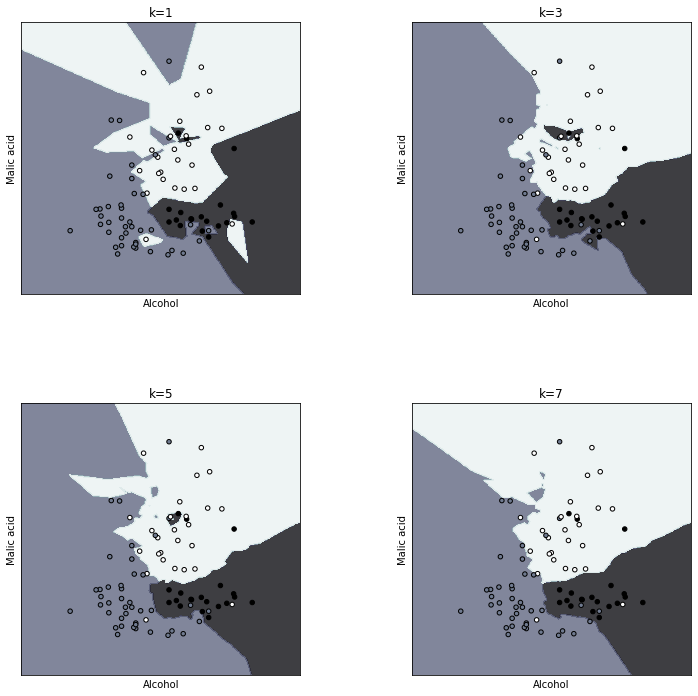

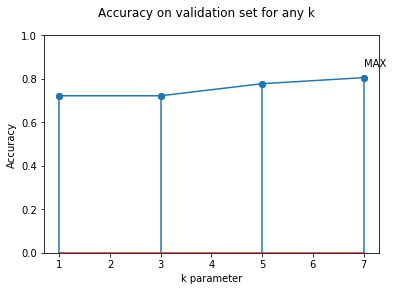

In [4]:
print("\n********************************")
print("TASK: kNN classification")
print("********************************\n")


best_score = 0
best_k = 1
knn_models = []
knn_accuracies = []

for k in [1, 3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    knn_models.append(knn)
    accuracy = knn.score(X_val, y_val)
    knn_accuracies.append(accuracy)
    if accuracy > best_score:
        best_score = accuracy
        best_k = k

print('Best prediction accuracy on validation set found with k = ' + str(best_k))
print('{:.2%}\n'.format(best_score))
        
plotModels(fignum=0, X=X_train, Y=y_train, models=knn_models, titles=[
           'k=1', 'k=3', 'k=5', 'k=7'], n=2)

plotAccuracyComparison(fignum=1, the_list=[1, 3, 5, 7], accuracy_list=knn_accuracies,
                       x_label='k parameter', title='Accuracy on validation set for any k', type='linear')

From these results we can see that the decision boundaries are really complex and non-linear, but they reflects well the classes (it is used the Voronoi tessellation to patition the space in regions and the boundary is a set of points at same distance from two different training examples). The boundaries changes because of the modification of the Voronoi’s tessellation that, given the set
of points and the k, it is fixed for every class.

### Model testing
After the best k value is found on the validation set, the model will be used on the test set, that must simulate *real world data*. An accuracy comparison plot is needed too.

In [5]:
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn.fit(X_trainval, y_trainval)
test_score = knn.score(X_test, y_test)
predictions = knn.predict(X_test)



print('Prediction accuracy on test set for k=' + str(best_k))
print('{:.2%}\n'.format(test_score))
print('report: \n' + classification_report(y_test, predictions))

Prediction accuracy on test set for k=7
81.48%

report: 
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.94      0.89      0.92        19
           2       0.64      0.58      0.61        12

    accuracy                           0.81        54
   macro avg       0.79      0.78      0.79        54
weighted avg       0.81      0.81      0.81        54



The main problem of the k-NN is the computational complexity in space and time, especially for big sets, that’s because some approximate versions are really used. 

For what concerns the evaluation of the model on the test set, it is good. We evaluate with the validation only on the 20% of the data, so the samples are not enough. Moreover, it must be recalled that dataset has been prepared (in the preprocessing stage) and from the *f1* in the report the cuttings on the other features cause lacks of informations regarding the *class_2*.

## Linear SVM: C tuning


### Model training and evaluation

As we already have done with the K-nn, we will train and evaluate one model for each value of C in our hyperparameter list:

**[0.001, 0.01, 0.1, 1, 10, 100, 1000]**

We want to choose the “C” that gives the highest accuracy when predicting the labels of the evaluation set.
If more than one C gives the same accuracy, we choose the lowest C, so the one that gives the larger margin. To train the models we instantiate a **SVM** for each C and we fit on the train set. At the same time we use the model to predict on the validation set and we save everything in a data structure and, using a personal library, we plot the seven models with the decision boundaries.


********************************
TASK: Linear SVM classification
********************************

Best prediction accuracy on validation set found with C = 1
66.67%



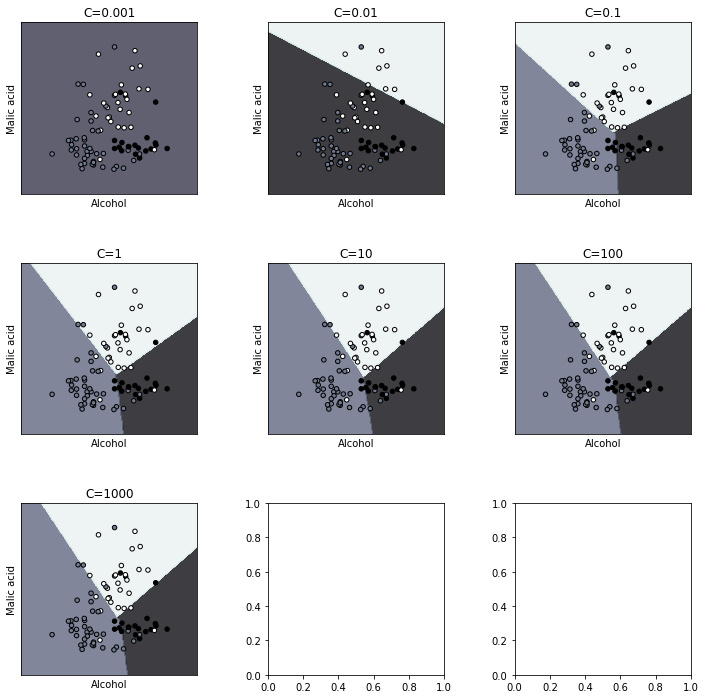

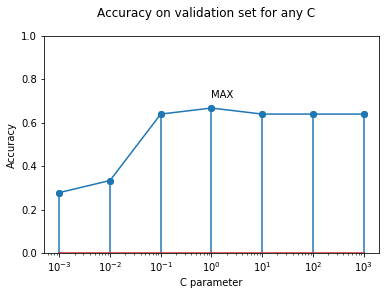

In [13]:
print("\n********************************")
print("TASK: Linear SVM classification")
print("********************************\n")

best_score = 0
best_C = 0
linearsvc_models = []
linearsvc_accuracies = []

for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svc = SVC(C=C, kernel='linear')
    svc.fit(X_train, y_train)
    linearsvc_models.append(svc)
    accuracy = svc.score(X_val, y_val)
    linearsvc_accuracies.append(accuracy)
    if accuracy > best_score:
        best_score = accuracy
        best_C = C

print('Best prediction accuracy on validation set found with C = ' + str(best_C))
print('{:.2%}\n'.format(best_score))

plotModels(fignum=10, X=X_train, Y=y_train, models=linearsvc_models, titles=['C=0.001', 'C=0.01', 'C=0.1', 'C=1', 'C=10', 'C=100', 'C=1000'], n=3)

plotAccuracyComparison(fignum=11, the_list=[0.001, 0.01, 0.1, 1, 10, 100, 1000], accuracy_list=linearsvc_accuracies,
                       x_label='C parameter', title='Accuracy on validation set for any C', type='log')

As we can see from the above graph, the accuracy is increasing for higher values of C, the model with the highest accuracy is in fact a small margin SVM: this means that the sample are not clearly linearly separable.


### Model testing

After the best C value is found on the validation set, the model will be used on the test set, that must simulate *real world data*. An accuracy comparison plot is required too (for every C).

In [8]:
svc = SVC(C=best_C, kernel='linear')
svc.fit(X_trainval, y_trainval)
test_score = svc.score(X_test, y_test)
predictions = svc.predict(X_test)



print('Prediction accuracy on test set for C=' + str(best_C))
print('{:.2%}\n'.format(test_score))
print('report: \n' + classification_report(y_test, predictions))

Prediction accuracy on test set for C=1
85.19%

report: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.90      1.00      0.95        19
           2       0.70      0.58      0.64        12

    accuracy                           0.85        54
   macro avg       0.82      0.82      0.82        54
weighted avg       0.84      0.85      0.85        54



The accuracy on the test set is really higher from what we expected. A possible cause can be intrinsic in our evaluation technique: we are not using enough samples to evaluate the model; a better result can be achieved using more advanced techniques, such as the one based on cross-validation (k-fold).  For what concerns the boundaries, we can obviously see that they are linear. That’s because we are solving the soft margin problem of the SVM linear classification adding a slack variable in the hard margin one and the C parameter in the objective function.


## RBF SVM: C tuning

Now we'll train and evaluate a SVM that uses the Radial Basis Function kernel instead of the linear one and we will proceed exactly as the previous steps.


### Model training and evaluation


********************************
TASK: RBF SVM classification
********************************

Prediction accuracy on validation set found with C = 10
80.56%



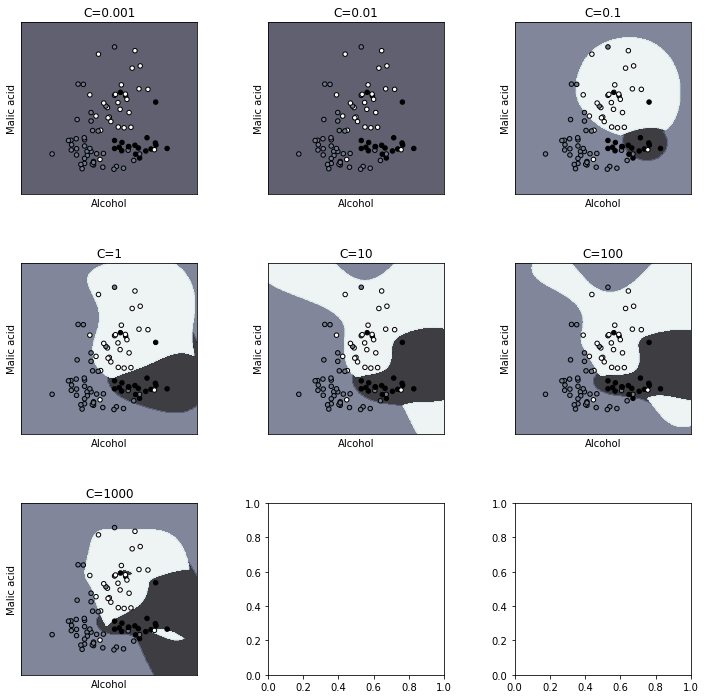

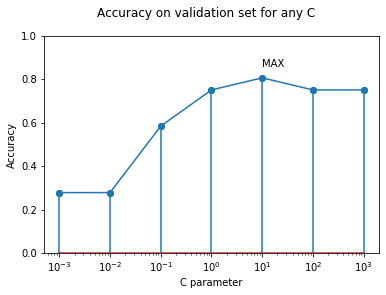

In [10]:
print("\n********************************")
print("TASK: RBF SVM classification")
print("********************************\n")

best_score = 0
best_C = 0
rbfsvc_models = []
rbfsvc_accuracies = []

for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svc = SVC(C=C, kernel='rbf', gamma='auto')
    svc.fit(X_train, y_train)
    rbfsvc_models.append(svc)
    accuracy = svc.score(X_val, y_val)
    rbfsvc_accuracies.append(accuracy)
    if accuracy > best_score:
        best_score = accuracy
        best_C = C

print('Best prediction accuracy on validation set found with C = ' + str(best_C))
print('{:.2%}\n'.format(best_score))

plotModels(fignum=12, X=X_train, Y=y_train, models=rbfsvc_models, titles=['C=0.001', 'C=0.01', 'C=0.1', 'C=1', 'C=10', 'C=100', 'C=1000'], n=3)

plotAccuracyComparison(fignum=13, the_list=[0.001, 0.01, 0.1, 1, 10, 100, 1000], accuracy_list=rbfsvc_accuracies,
                       x_label='C parameter', title='Accuracy on validation set for any C', type='log')


In this case, as the problem was not linearly separable (on the valuation set), here we have found a muche better score. The C let behaves the boundaries as a large margin classifier at the
beginning and the as a narrow margin classifier at the end (large C).


### Model testing

In [14]:
svc = SVC(C=best_C, kernel='rbf', gamma='auto')
svc.fit(X_trainval, y_trainval)
test_score = svc.score(X_test, y_test)
predictions = svc.predict(X_test)


print('Prediction accuracy on test set for C=' + str(best_C))
print('{:.2%}\n'.format(test_score))
print('report: \n' + classification_report(y_test, predictions))

Prediction accuracy on test set for C=1
83.33%

report: 
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.90      0.95      0.92        19
           2       0.70      0.58      0.64        12

    accuracy                           0.83        54
   macro avg       0.81      0.80      0.80        54
weighted avg       0.83      0.83      0.83        54



This time we got an accuracy that is better with respect to the one found during the evaluation. The RBF SVM is built applying the kernel trick to maximum-margin hyperplanes. The resulting algorithm is formally similar, except that every dot product is replaced by a non-linear kernel function. This allows the algorithm to fit the maximum-margin hyperplane in a transformed feature space. The transformation may be non-linear and the transformed space high-dimensional; although the classifier is a hyperplane in the transformed feature space, it may be nonlinear in the original input space. In our case (RBF as kernel function) the boundaries are exactly the practical implication of the RBF as thekernel trick; in fact they resembles to linked gaussian functions drawn at different shapes.
The problem of too little informations on the *class_2* persists, we will use at the end the PCA combined with a Scaler.

## RBF SVM: grid-search (C and gamma)

Let’s now make two lists of values for the two hyperparameters of the SVM that we want to tune: C and, since we are using a RBF Kernel, γ. It is necessary to tell that the γ parameter was in the RBF with only C tuning too. The difference is that if we do not explicitly pass it, the default value of γ is 1/n_features. The margin width of the SVM is directly proportional to 1/C, so for value of C >> 1 we’ll get a narrow margin, this means that our model will behave like a small margin SVM, thus the decision boundaries will depend only on fewer samples.  Instead, if 0 < C < 1, our model will behave like a large margin classifier, thus expanding the margin such that the decision boundary position will be influenced by more points. If we choose a small margin (large C), we don’t trust that our data are well separated, so it will be difficult to classify them, and in this case, a small margin will help. But if the margin is too small, it could be impractical to separate the classes using too few samples as support vectors. The γ parameter is specific for the SVM that uses an RBF kernel, it defines the distance of influence of each sample. Now we’ll train a SVM that uses the RBF kernel, and we’ll choose the best hyperparameters C and γ that give us the highest accuracy when predicting the labels. We need to train and test a SVM for each couple of parameters, performing a grid search over the accuracies obtained by each model, and selecting the values of C and γ used by the model that performed the best.

### Model training and evaluation
As we already done previously, we use the **SVM** class with a nested for loopto create every possible model.


********************************
TASK: RBF SVM classification with grid-search
********************************

Prediction accuracy on validation set found with C = 100 and gamma = 1
77.78%



Text(0.5, 1.0, 'Validation accuracy')

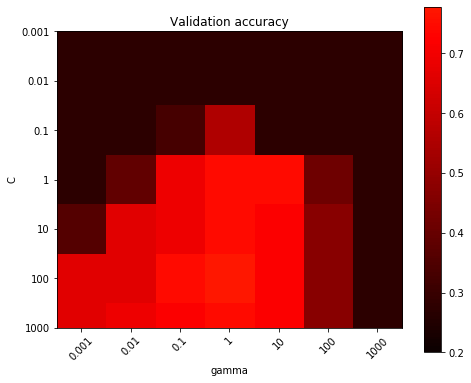

In [12]:
print("\n********************************")
print("TASK: RBF SVM classification with grid-search")
print("********************************\n")

best_score = 0
best_C = 0
best_gamma = 0
gridsvc_models = []
gridsvc_accuracies = []

for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        svc = SVC(C=C, kernel='rbf', gamma=gamma)
        svc.fit(X_train, y_train)
        gridsvc_models.append(svc)
        accuracy = svc.score(X_val, y_val)
        gridsvc_accuracies.append(accuracy)
        if accuracy > best_score:
            best_score = accuracy
            best_C = C
            best_gamma = gamma

print('Best prediction accuracy on validation set found with C = ' + str(best_C) + ' and gamma = ' + str(best_gamma))
print('{:.2%}\n'.format(best_score))


scores = np.array(gridsvc_accuracies).reshape(len([0.001, 0.01, 0.1, 1, 10, 100, 1000]), len([0.001, 0.01, 0.1, 1, 10, 100, 1000]))

plt.figure(num=9, figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len([0.001, 0.01, 0.1, 1, 10, 100, 1000])), [0.001, 0.01, 0.1, 1, 10, 100, 1000], rotation=45)
plt.yticks(np.arange(len([0.001, 0.01, 0.1, 1, 10, 100, 1000])), [0.001, 0.01, 0.1, 1, 10, 100, 1000])
plt.title('Validation accuracy')

### Model testing

Now that we have choosen the best values for Gamma and C, we can train a model with this parameters and test it on the test set.

In [15]:
svc = SVC(C=best_C, kernel='rbf', gamma=best_gamma)
svc.fit(X_trainval, y_trainval)
test_score = svc.score(X_test, y_test)
predictions = svc.predict(X_test)



print('Prediction accuracy on test set for C = ' + str(best_C) + ' and gamma = ' + str(best_gamma))
print('{:.2%}\n'.format(test_score))
print('report: \n' + classification_report(y_test, predictions))

Prediction accuracy on test set for C = 1 and gamma = 1
83.33%

report: 
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.90      0.95      0.92        19
           2       0.70      0.58      0.64        12

    accuracy                           0.83        54
   macro avg       0.81      0.80      0.80        54
weighted avg       0.83      0.83      0.83        54



This time we plotted a heatmap that shows the accuracy obtained by each model trained with a different couple of parameters. As we can see from the plot there is a specific region of the heatmap populated by high accuracy values: also in this case, a very small value of C doesn't works well to classify our samples. Moreover, an high value of γ isn't working very well, even if we have an high value for C. We obtained the same accuracy on the test set w.r.t. the "only C" RBF. That’s because probably theγis automatically chosen in the "only C" one and it is similar to the one in the grid-search.


## RBF SVM: 5-fold cross-validation

Now we’ll use the K-fold cross-validation technique to validate our models. As usual, we want to find the values of C and γ that give us the highest accuracy.
By using cross-validation, we are not splitting the dataset into three parts, but we are splitting it only into a training set and a test set.  The training set will then be splitted into a number of “K” different sets, called “folds”, and we’ll perform K rounds of training and evaluation, each time training on K-1 folds, and validating on the remaining fold. This will allow to perform the validation more in depth, by using more samples. We have a chance that by doing this we’ll tune the model with the right parameters.

### Cross-validation and testing

We'll first divide the dataset into training and test sets, then we'll use a pipe composed by a **StandardScaler** and a **SVC** classifier. After that the params are defined and the **KFold** of 5 is instantiated we run the **GridSearchSV** using as estimator the pipe (in order to normalize only one fold at a time at runtime) and as folds the *X_train* splitted.

In [16]:
print("\n********************************")
print("TASK: RBF SVM classification with k-fold")
print("********************************\n")

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

pipe = Pipeline([
    ('mm', MinMaxScaler()),
    ('svc', SVC(kernel='rbf'))
])

params = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

kfold = KFold(5)

search = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    n_jobs=-1,
    iid=False,
    cv=kfold.split(X=X_trainval, y=y_trainval),
    return_train_score=True
)


kfoldSVC = search.fit(X_trainval, y_trainval)

result = kfoldSVC.best_estimator_.score(X_test, y_test)
predictions = kfoldSVC.best_estimator_.predict(X_test)



print("Best average score found for C = " + str(kfoldSVC.best_params_['svc__C']) + " and gamma = " + str(kfoldSVC.best_params_['svc__gamma'])
+ "\n-> " + '{:.2%}\n'.format(kfoldSVC.best_score_))

print("Score applying it on the test set -> " + '{:.2%}\n'.format(result))
print('report: \n' + classification_report(y_test, predictions))


********************************
TASK: RBF SVM classification with k-fold
********************************

Best average score found for C = 1 and gamma = 10
-> 81.37%

Score applying it on the test set -> 83.33%

report: 
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.90      0.95      0.92        19
           2       0.70      0.58      0.64        12

    accuracy                           0.83        54
   macro avg       0.81      0.80      0.80        54
weighted avg       0.83      0.83      0.83        54



Finally, we obtained an accuracy on par with the one obtained during the evaluation (it is almost the same).  As we said, this is because we are deciding which parameters to use by performing a much deeper analysis:  thanks to the cross-validation technique, we are using near four times (k-1) more samples to evaluate the models. Unfortunately we do not have any possibility to gain our accuracy, because of the loss of informations caused at the start choosing only the first 2 features.

## Performances with 2-PCA and normalization 

In this last task we'll show how it is important the principal component analysis: instead of losing informations by discarding all the features but two, we can run a PCA to reduce all the features in a *synthetized* 2D representation in order to lose as little as possible informations about the original dataset. In addiction, scaling the data could improve the prediction accuracy because of some samples that are "out of order".

This is done in another script and imported directly (nothing to say for what concerns the code, it is simply added the PCA indtead of the cutting).

The performances are, obviously, really good: the prediction on the test set reaches everytime 98% or more. This is a dimonstration on the fact that pre-processing is the first key to archive the best performance on our ML algorithm.

In [33]:
%load withPCA.py


********************************
TASK: kNN classification
********************************

Prediction accuracy on validation set found with k = 3
94.44%

Prediction accuracy on test set for k=3
96.30%

report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       0.95      0.95      0.95        19
           2       1.00      0.92      0.96        12

    accuracy                           0.96        54
   macro avg       0.97      0.95      0.96        54
weighted avg       0.96      0.96      0.96        54


********************************
TASK: Linear SVM classification
********************************

Prediction accuracy on validation set found with C = 0.1
94.44%

Prediction accuracy on test set for C=0.1
96.30%

report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       0.95      0.95      0.95        19
           2       